In [1]:
#Credit: https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from sklearn.cross_validation import train_test_split
from collections import defaultdict
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text 
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import re
#import findspark
#findspark.init()
#import pyspark
#from pyspark.sql import SQLContext
import nltk
import pprint
#nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram
stopwords=text.ENGLISH_STOP_WORDS
DATAFILEPATH='/Users/Dilip_MBP/Documents/CS109/PROJECT/project_cs109/data/'
#DATAFILEPATH='/Users/Dilip_MBP/Documents/CS109/PROJECT/data/'
#DATAFILEPATH='C:/Users/balachandrd/Documents/Personal/CS-109/Project/project_cs109/data/'

In [2]:
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
regex3=re.compile(r"\\\\")
stopwords=text.ENGLISH_STOP_WORDS

#Since we are looking for only nouns, we want to avoid parsing for most popular words such as 'bike' and 'bicycle'
CUSTOM_STOPWORDS_NOUN=['bike', 'bicycle']
CUSTOM_STOPWORDS=['']


In [3]:
bike_masterdf = pd.read_csv(DATAFILEPATH+'bike_details.csv',encoding='utf-8')
print "Number of samples in the database:", bike_masterdf.shape[0]
bike_masterdf.head(2)

Number of samples in the database: 59619


Unnamed: 0     id                               title          serial manufacturer_name        frame_model  year thumb large_img is_stock_img stolen stolen_location          date_stolen registration_created_at registration_updated_at                                url                                   api_url  manufacturer_id paint_description name frame_size description rear_tire_narrow front_tire_narrow type_of_cycle test_bike  rear_wheel_size_iso_bsd  front_wheel_size_iso_bsd  \
0           0  50088                     Schwinn Gateway          absent           Schwinn            Gateway   NaN   NaN       NaN        False  False             NaN  1970-01-01 00:00:00     2015-07-06 22:27:01     2015-11-03 05:36:54  https://bikeindex.org/bikes/50088  https://bikeindex.org/api/v1/bikes/50088              117               NaN  NaN        NaN         NaN             True               NaN          Bike     False                      NaN                       NaN   
1           1  60140  2016 Specialized Diverge Elite DSW  WSBC601010269K       Specialized  Diverge Elite DSW  2016   NaN       NaN        False  False             NaN  1970-01-01 00:00:00     2015-10-08 19:18:50     2015-11-03 05:34:30  https://bikeindex.org/bikes/60140  https://bikeindex.org/api/v1/bikes/60140              307               NaN  NaN       52cm         NaN             True               NaN          Bike     False                      NaN                       NaN   

  handlebar_type_slug frame_material_slug front_gear_type_slug rear_gear_type_slug  stolen_id  s_date_stolen s_location  latitude  longitude theft_description locking_description lock_defeat_description police_report_number police_report_department     s_rec_created_at create_open311 sder_formatted_address sder_street_number sder_route sder_postal_code sder_neighborhood sder_city sder_county sder_state sder_country  date_stolen_epoch  registration_created_at_epoch  \
0                 NaN                 NaN                  NaN                 NaN        NaN            NaN        NaN       NaN        NaN               NaN                 NaN                     NaN                  NaN                      NaN  1970-01-01 00:00:00            NaN                    NaN                NaN        NaN              NaN               NaN       NaN         NaN        NaN          NaN                  0                     1436221621   
1                 NaN            aluminum                  NaN                 NaN        NaN            NaN        NaN       NaN        NaN               NaN                 NaN                     NaN                  NaN                      NaN  1970-01-01 00:00:00            NaN                    NaN                NaN        NaN              NaN               NaN       NaN         NaN        NaN          NaN                  0                     1444331930   

   registration_updated_at_epoch  s_rec_created_at_epoch  
0                     1446529014                       0  
1                     1446528870                       0

### Taking a peek

From the above excerpt of theft description, we can already see that some descriptions are almost too abrupt and to the point e.g. bike rack, thereby relaying very little information other than where the bike was prior to theft. Some  descriptions detail on how the bike was secured prior to theft and other descriptions talk about renumerations. There definitely is a lot of text cleaning that is required. 

In [4]:
# Remove nulls in theft description - only stolen bikes have theft description -> store in filtered dataframe
num_stolen = len(bike_masterdf.stolen[bike_masterdf.stolen == True])
print "Number of bikes reported as stolen: ", num_stolen
print "Proportion of bikes reported as stolen:  %.2f" % (float(num_stolen)/float(bike_masterdf.shape[0]))
desc_mask = bike_masterdf.theft_description.isnull()
bike_subdf1 = bike_masterdf[~desc_mask]
desc_mask2 = bike_subdf1.theft_description == ' '
bike_subdf = bike_subdf1[~desc_mask2]
print "Number of Stolen bikes with theft description:", bike_subdf.shape[0]

bike_subdf.to_csv(DATAFILEPATH+'stolen_bikes.csv',encoding='utf-8')
bike_subdf.head(20)

Number of bikes reported as stolen:  33182
Proportion of bikes reported as stolen:  0.56
Number of Stolen bikes with theft description: 28728


Unnamed: 0     id                                       title               serial manufacturer_name                frame_model  year                                              thumb                                          large_img is_stock_img stolen           stolen_location          date_stolen registration_created_at registration_updated_at                                url                                   api_url  manufacturer_id paint_description name frame_size  \
3            3  11542                              2013 Trek 4300         WTU124C5170G              Trek                       4300  2013                                                NaN                                                NaN        False   True       San Jose, CA, 95126  2013-06-10 06:00:00     2013-08-20 06:00:00     2015-11-03 05:11:14  https://bikeindex.org/bikes/11542  https://bikeindex.org/api/v1/bikes/11542               47               NaN  NaN        NaN   
4            4  13359                         2010 Schwinn Katana               absent           Schwinn                     Katana  2010  https://files.bikeindex.org/uploads/Pu/4903/sm...  https://files.bikeindex.org/uploads/Pu/4903/la...        False   True       Sandusky, OH, 44870  2010-07-10 06:00:00     2010-07-11 06:00:00     2015-11-03 05:17:53  https://bikeindex.org/bikes/13359  https://bikeindex.org/api/v1/bikes/13359              117               NaN  NaN       58cm   
5            5  11540              Motobecane Fantom Cross (pro?)               absent        Motobecane        Fantom Cross (pro?)   NaN  https://files.bikeindex.org/uploads/Pu/4383/sm...  https://files.bikeindex.org/uploads/Pu/4383/la...        False   True       Portland, OR, 97202  2013-08-20 06:00:00     2013-08-20 06:00:00     2015-11-03 05:10:30  https://bikeindex.org/bikes/11540  https://bikeindex.org/api/v1/bikes/11540              234               NaN  NaN        NaN   
6            6  11541                        2007 Trek 7.3 FX WSD         WTU345C2237B              Trek                 7.3 FX WSD  2007                                                NaN                                                NaN        False   True       Berkeley, CA, 94709  2009-08-29 06:00:00     2009-09-15 06:00:00     2015-11-03 05:19:08  https://bikeindex.org/bikes/11541  https://bikeindex.org/api/v1/bikes/11541               47               NaN  NaN       15in   
7            7  11546                              2009 Trek 4300         WTU364C1402D              Trek                       4300  2009  https://bikebook.s3.amazonaws.com/uploads/Fr/1...  https://bikebook.s3.amazonaws.com/uploads/Fr/1...         True   True     Washington, DC, 20037  2009-09-07 06:00:00     2009-09-16 06:00:00     2015-11-03 05:19:06  https://bikeindex.org/bikes/11546  https://bikeindex.org/api/v1/bikes/11546               47               NaN  NaN     19.5in   
8            8  11547                                   Peugeot ?               absent           Peugeot                          ?   NaN                                                NaN                                                NaN        False   True       Portland, OR, 97202  2009-09-16 06:00:00     2009-09-17 06:00:00     2015-11-03 05:19:02  https://bikeindex.org/bikes/11547  https://bikeindex.org/api/v1/bikes/11547              102               NaN  NaN       56cm   
9            9  11544         2012 Marin Bikes Bolinas Ridge 29er        JH122601JD011       Marin Bikes         Bolinas Ridge 29er  2012  https://files.bikeindex.org/uploads/Pu/4384/sm...  https://files.bikeindex.org/uploads/Pu/4384/la...        False   True  Portland, OR, 97216-2117  2013-10-21 06:00:00     2013-10-22 06:00:00     2015-11-03 05:09:48  https://bikeindex.org/bikes/11544  https://bikeindex.org/api/v1/bikes/11544              219               NaN  NaN       29in   
10          10  13358  2006 Gary Fisher Tiburon - Men\\'s Hyrbrid         WTU246C0860A       Gary Fisher  Tiburon - 

In [5]:
#Peek at theft description

print (bike_subdf.theft_description[0:15])

3                                             bike rack
4                             car bike rack Reward: $75
5                      Backyard Reward: I have no money
6                              Open Garage Reward: $300
7     15\\" thick steel hand railing to which my bik...
8                              Powell Park Reward: $100
9                 PCC SE Campus at SE 82nd and Division
10                                         Reward: $150
11    A bike rack. Reward: A BIG HUG, MAYBE MONEY TO...
14                                         McDonald\\'s
15                                bike rack Reward: 200
16                                bike rack Reward: 200
17                              se 19th and se brooklyn
18    2131 NE 11th Ave Portland, OROut of my garage ...
19                         Outside of 120 NW Trinity Pl
Name: theft_description, dtype: object


Theft description with maximum word count: 558
Theft description with minimum word cunt:  1
Average word count of description: 10.61


/Users/Dilip_MBP/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


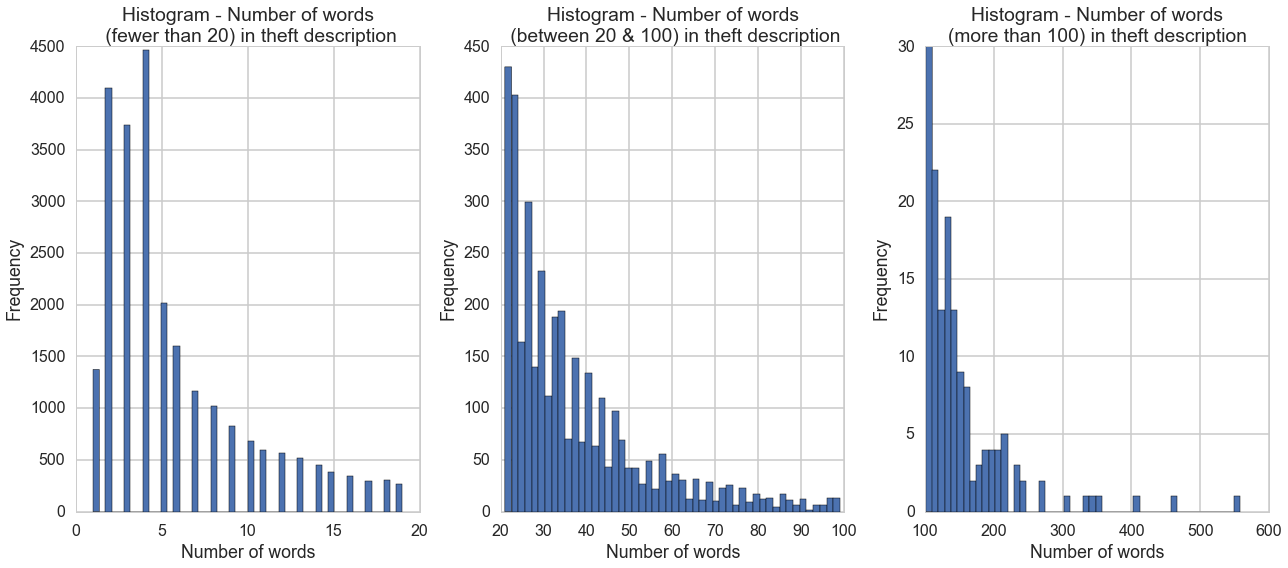

In [6]:
#Peek at the description data - Basic exploratory analysis

# Split each theft description to number of words to get an idea of how long the descriptions are
# exploratory
theft_desc_word_count = bike_subdf.theft_description.apply(lambda x: len(x.split()))


print "Theft description with maximum word count:", max(theft_desc_word_count)
print "Theft description with minimum word cunt: ", min(theft_desc_word_count)
print "Average word count of description: %.2f" % np.mean(theft_desc_word_count)
theft_desc_word_count_small = theft_desc_word_count[theft_desc_word_count < 20]
theft_desc_word_count_mid = theft_desc_word_count[(theft_desc_word_count > 20) & (theft_desc_word_count < 100)]
theft_desc_word_count_large = theft_desc_word_count[theft_desc_word_count > 100]
#theft_desc_word_count_small.tolist

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8), tight_layout=True)
ax1.hist(theft_desc_word_count_small.tolist(), bins=50,histtype='bar' )
ax1.set_title('Histogram - Number of words \n (fewer than 20) in theft description')
ax1.set_xlabel('Number of words')
ax1.set_ylabel('Frequency')
ax2.hist(theft_desc_word_count_mid.tolist(), bins=50,histtype='bar' )
ax2.set_title('Histogram - Number of words \n (between 20 & 100) in theft description')
ax2.set_xlabel('Number of words')
ax2.set_ylabel('Frequency')
ax3.hist(theft_desc_word_count_large.tolist(), bins=50,histtype='bar' )
ax3.set_title('Histogram - Number of words \n(more than 100) in theft description')
ax3.set_xlabel('Number of words')
ax3.set_ylabel('Frequency')

### Theft description as a bunch of words

The sentences in theft description were split in to individual words to get an understanding of the amount of effort put by the bike owners in to describing the theft. The average number of words per description is about 10-11 where as there are exceptions with 558 as being the maximum and some with as very little as 1. 

The above histogram gives an idea of the text distribution. A large number of theft descriptions are fewer than 5 words, with 2 and 4 words per description being the most common. There is a substantial dip in the number theft descriptions with 20 to 100 words. The dip is seen once again past the 100 word mark. 

This goes to show that bike owners typically take less interest in detailing the theft while submitting information about theft. It also could be that those who chose to write fewer words possibly had less expensive bikes vs those who chose to write more than 100 words. Those who wrote detailed descriptions possibly had expensive bikes and wanted to give as much information as possible or are really thorough in their work.

In [7]:
# Create function to parse incoming text, tokenize and check for  ******* Nouns
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
regex3=re.compile(r"\\\\")
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

def gather_nouns(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    thetext=re.sub(regex3, ' ', thetext)
    thetext = thetext.lower()
    nouns=[]
    for sentence in parse(thetext, tokenize=True, lemmata = True, encoding = 'utf-8').split():
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['NN', 'NNS']:
                    if token[4] in CUSTOM_STOPWORDS_NOUN or token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns.append(token[4])
    nouns2=[]

    for n in nouns:
        if len(n)!=0:
            nouns2.append(n)
        else:
            print "************** WE HAVE A PROBLEM **************"
    return ' '.join(nouns2)


def gather_nouns_and_adj(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    thetext=re.sub(regex3, ' ', thetext)
    thetext = thetext.lower()
    tokens=[]
    for sentence in parse(thetext, tokenize=True, lemmata = True, encoding = 'utf-8').split():
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['NN','NNS','NNP','JJ','JJR','JJS' ]:
                    if token[4] in CUSTOM_STOPWORDS or token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    
                    #print token[4]    
                    tokens.append(token[4])
    tokens2=[]

    for n in tokens:
        if len(n)!=0:
            tokens2.append(n)
            # Remove repeating bigrams (e.g bike bike)
            if (len(tokens2) !=1):
                if (tokens2[-1] == tokens2[-2]):
                    tokens2.pop()
            
            
                            
        else:
            print "************** WE HAVE A PROBLEM **************"
    return ' '.join(tokens2)

In [8]:
# Test parsing functions to understand if parsing will be fine
# Following sentence was constructed on the fly and does not belong to the BikeIndex data

atext = "The bikes were locked to a sign pole in my apartment by the corner of the superstore. The lock was a combination lock and i had \
tied chained my helmet to the bike. We have fairly good security in the block of apartments here. The bike was of make 'GT' with shimano \
gears and had a custom seat. The apartment's security office told me that i have no chance of retrieving the bike. My counsin' bike was \
stolen from their home's open garage overnight reward"

print gather_nouns(atext)
print "\n"
print gather_nouns_and_adj(atext)
print "\n"




sign pole apartment corner superstore lock combination lock helmet security block apartment make gt shimano gear custom seat apartment security office chance counsin home garage reward


bike sign pole apartment corner superstore lock combination lock helmet bike good security block apartment bike make gt shimano gear custom seat apartment security office chance bike counsin bike home open garage overnight reward




### Parse Nouns
Theft description data takes on a broad spectrum when it comes to context. Each owner posting theft description has their own style, can decide to be very specific or elaborate about the theft, could decide to focus on location of theft and describing the bike itself or could describe the circumstances yielding to the bike theft. Given that theft description can be approached from multiple angles, we shall start with gathering only the nouns from the description. The nouns will give an idea of 'what', 'where'. We are not really interested in the 'when'. If the data provided to us the 'Who' and 'Why', then the investigation could assume a different angle. 

In this discussion, we shall only focus on the 'what' and 'where'. Note that 'where' is already available in terms if 'location/city/coordinates' in the data. However, the 'where' here will be focussing on the type of property and its specifics.  We start with noun 'unigram' parsing.

Note: As part of the stop words used for parsing the text, the words 'bike' and 'bicycle' were added to the stop words to avoid cluttering the parsed words with redundant information. This is only applicable if we are parsing for single words and NOT for bigrams or when looking for adjectives that may describe the theft.

In [9]:
# Parse Theft description for Nouns 
# Clean resulting data frame to remove null entries where no nouns were parsed from theft description
# Apply gather_nouns function, convert to dataframe and attach to original data frame for storing to file

noun_parsed = bike_subdf.theft_description.map(gather_nouns)

noun_parsed = noun_parsed.to_frame()

noun_parsed.columns = ['theft_desc_nouns']


#Merge new dataframe with original
newdf = pd.concat([bike_subdf, noun_parsed], axis=1)

#Remove theft desc where cell is null/empty
null_mask = newdf.theft_desc_nouns == ''
bike_df_clean = newdf[~null_mask].copy()
bike_df_clean['theft_desc_nouns'].head(10)

3                          rack
4               car rack reward
5         backyard reward money
6                 garage reward
7     steel hand railing u-lock
8            powell park reward
9               campus division
10                       reward
11        rack reward hug money
14                     mcdonald
Name: theft_desc_nouns, dtype: object

In [10]:
#Tokenize each theft description to return a list of nouns (ONLY)
# We will remove words whose word count is less than 2

vectorizer_nouns = CountVectorizer(min_df=2, stop_words='english')
nouns_sparse_matrix = vectorizer_nouns.fit_transform(bike_df_clean.theft_desc_nouns)

In [11]:
# From vectorizer, gather word-frequency data to look for highy frequency words
#Credit: http://stackoverflow.com/questions/16078015/list-the-words-in-a-vocabulary-according-to-occurrence-in-a-text-corpus-scikit

Nouns = vectorizer_nouns.get_feature_names()
Noun_Counts = np.asarray(nouns_sparse_matrix.sum(axis=0)).ravel()
Nouns_Freq = pd.DataFrame({'Nouns': Nouns, 'Count':Noun_Counts})
Sorted_Nouns_Freq = Nouns_Freq.sort(columns='Count', ascending=False)
Sorted_Nouns_Freq.to_csv(DATAFILEPATH+'Nouns_frequency.csv',encoding='utf-8')

### Nouns

Prior to doing any more analysis, we need to understand the frequency of the nouns in the descriptions. Given that the nouns will be descibing the 'what' and 'where' of the theft, we can expect a select set of words to be highly frequent among theft descriptions. Some of these words may make sense and other may not. At the same time, there will be a lot of words that may not be relevant to point of this investigation ('where').  As there can only be a handful of popular locations/points from which a bicycle can be stolen, we can preset this number temporarily to less than 100 and explore the data. Following graph, shows the top 90 words in the dataset.

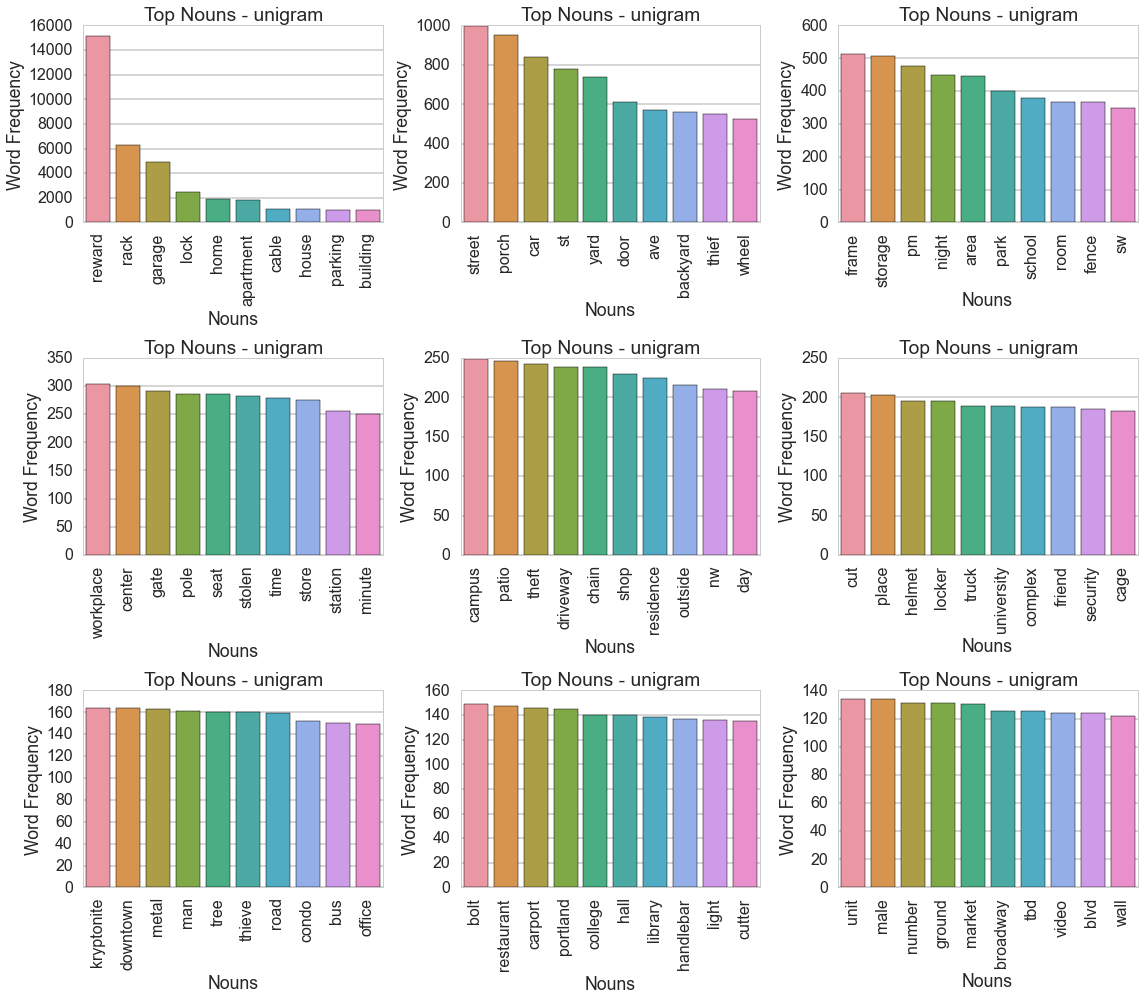

In [12]:
# Plot bar graph of Frequency of top 200 words that were vectorized 
#
def plot_freq_chart(nrows, ncols, df_in, title_in) :
    x_label = df_in.columns[1]
    y_label = df_in.columns[0]
    plt_rows = np.arange(nrows)
    plt_cols = np.arange(ncols)
    f1, ax1 = plt.subplots(figsize=(16,14), nrows=nrows, ncols=ncols)
    f1.set_tight_layout(True)
    x = 0
    #sns.barplot(x='Nouns',y='Count',data= sorted_w_freq_df[0:10])
    for row in plt_rows:
        for col in plt_cols:
            a = sns.barplot(x=x_label,y=y_label,data=df_in[x:x+10], ax=ax1[row][col])
            #print row,col
            a.set_xticklabels(df_in[x_label][x:x+10].tolist(), rotation='vertical')
            a.set_ylabel('Word Frequency')
            a.set_title(title_in)
            x+=10
        x+=10

nrows=3
ncols=3

plot_freq_chart(3,3,Sorted_Nouns_Freq, "Top Nouns - unigram")

### Analysis of Nouns Word count

It is very surprising to note that the word 'reward' is the most frequently used word in the descriptions. Shows that a lot of bike owners are willing to give a reward if a bike is found. Looking at the other words in list, there is a lot of information available on exactly where the bike was stolen from. The above chart indicates that we may be missing part story if only focussing on the nouns. Here are few examples to illustrate the point:

a) word: rack
The word rack alone is unable to convey much information as the bicycle could have been on a rack in the garage, on the street, in a building etc.  

b) word: condo
Simply parsing the nouns for unigram definitely yields in disecting words such as condo apartment, resulting in two separate words; condo and apartment.

c) word: friend
The word friend by itself does not provide any information about the 'where' or 'what' that we are interested in. 

d) word: pole
The word pole is mostly associated with another noun and we lose the context of the description by looking for unigrams alone

The above exploration of the nouns word count indicates that looking at unigrams alone may/may not be helpful in identifying the 'what' that we are interested in.  To help us understand the descriptions better, we will proceed with parsing for bi-grams along with 'adjectives' in order to provide more meaning to words such as 'bolt', 'chain', 'room', 'fence' etc.


In [13]:
#TEMP To DEL
Sorted_Nouns_Freq.columns[0]

'Count'

In [14]:
##############################################################################################
#Approaching parsing text as bi-grams: Bigrams would include both adjective and noun together

noun_adj_parsed = bike_subdf.theft_description.apply(gather_nouns_and_adj)
noun_adj_parsed = noun_adj_parsed.to_frame()
noun_adj_parsed.columns = ['theft_desc_nouns_adj']
print "bike data frame shape before appending bigrams: ", bike_df_clean.shape
#Merge new dataframe with original
newdf1 = pd.concat([bike_df_clean, noun_adj_parsed], axis=1)

#Remove theft desc where cell is null/empty
null_mask1 = newdf1.theft_desc_nouns_adj == ''
bike_df_clean = newdf1[~null_mask1].copy()
print "bike data frame shape after appending bigrams: ", bike_df_clean.shape
bike_df_clean.head(5)



bike data frame shape before appending bigrams:  (28402, 58)
bike data frame shape after appending bigrams:  (28534, 59)


Unnamed: 0     id                           title        serial manufacturer_name          frame_model  year                                              thumb                                          large_img is_stock_img stolen        stolen_location          date_stolen registration_created_at registration_updated_at                                url                                   api_url  manufacturer_id paint_description name frame_size  \
3           3  11542                  2013 Trek 4300  WTU124C5170G              Trek                 4300  2013                                                NaN                                                NaN        False   True    San Jose, CA, 95126  2013-06-10 06:00:00     2013-08-20 06:00:00     2015-11-03 05:11:14  https://bikeindex.org/bikes/11542  https://bikeindex.org/api/v1/bikes/11542               47               NaN  NaN        NaN   
4           4  13359             2010 Schwinn Katana        absent           Schwinn               Katana  2010  https://files.bikeindex.org/uploads/Pu/4903/sm...  https://files.bikeindex.org/uploads/Pu/4903/la...        False   True    Sandusky, OH, 44870  2010-07-10 06:00:00     2010-07-11 06:00:00     2015-11-03 05:17:53  https://bikeindex.org/bikes/13359  https://bikeindex.org/api/v1/bikes/13359              117               NaN  NaN       58cm   
5           5  11540  Motobecane Fantom Cross (pro?)        absent        Motobecane  Fantom Cross (pro?)   NaN  https://files.bikeindex.org/uploads/Pu/4383/sm...  https://files.bikeindex.org/uploads/Pu/4383/la...        False   True    Portland, OR, 97202  2013-08-20 06:00:00     2013-08-20 06:00:00     2015-11-03 05:10:30  https://bikeindex.org/bikes/11540  https://bikeindex.org/api/v1/bikes/11540              234               NaN  NaN        NaN   
6           6  11541            2007 Trek 7.3 FX WSD  WTU345C2237B              Trek           7.3 FX WSD  2007                                                NaN                                                NaN        False   True    Berkeley, CA, 94709  2009-08-29 06:00:00     2009-09-15 06:00:00     2015-11-03 05:19:08  https://bikeindex.org/bikes/11541  https://bikeindex.org/api/v1/bikes/11541               47               NaN  NaN       15in   
7           7  11546                  2009 Trek 4300  WTU364C1402D              Trek                 4300  2009  https://bikebook.s3.amazonaws.com/uploads/Fr/1...  https://bikebook.s3.amazonaws.com/uploads/Fr/1...         True   True  Washington, DC, 20037  2009-09-07 06:00:00     2009-09-16 06:00:00     2015-11-03 05:19:06  https://bikeindex.org/bikes/11546  https://bikeindex.org/api/v1/bikes/11546               47               NaN  NaN     19.5in   

                                         description rear_tire_narrow front_tire_narrow type_of_cycle test_bike  rear_wheel_size_iso_bsd  front_wheel_size_iso_bsd handlebar_type_slug frame_material_slug front_gear_type_slug rear_gear_type_slug  stolen_id  s_date_stolen             s_location   latitude   longitude                                  theft_description locking_description lock_defeat_description police_report_number police_report_department     s_rec_created_at create_open311  \
3  Trek 4300, Mountain bicycle, disc brakes, blac...             True               NaN          Bike     False                      NaN                       NaN                 NaN                 NaN                  NaN                 NaN       7889     1370844000    San Jose, CA, 95126  37.329012 -121.916021                                          bike rack                 NaN                     NaN            T13006853                 San Jose  2014-06-14 17:52:49          False   
4  The bike is a grey, blue, and black Schwinn Ka...             True               NaN          Bike     False                      NaN                       NaN                 NaN                 NaN                  NaN                 NaN       9705     127874160



A preliminary peek in to the dataframe created from parsing for adjectives and nouns already seem to be providing more detail. e.g. 'open garage' which we did not earlier when parsing for nouns only. 

In [15]:
#Vectorizer for bigrams
vectorizer_nouns_adj = CountVectorizer(min_df=2, ngram_range=(2,2), stop_words='english')
nouns_adj_sparse_matrix = vectorizer_nouns_adj.fit_transform(bike_df_clean.theft_desc_nouns_adj) 

Nouns_Adj = vectorizer_nouns_adj.get_feature_names()
Nouns_Adj_Counts = np.asarray(nouns_adj_sparse_matrix.sum(axis=0)).ravel()
Nouns_Adj_Freq = pd.DataFrame({'Nouns_Adjectives': Nouns_Adj, 'Count':Nouns_Adj_Counts})
Sorted_Nouns_Adj_Freq = Nouns_Adj_Freq.sort(columns='Count', ascending=False)
Sorted_Nouns_Adj_Freq.to_csv(DATAFILEPATH+'Nouns_Adj_frequency.csv',encoding='utf-8')

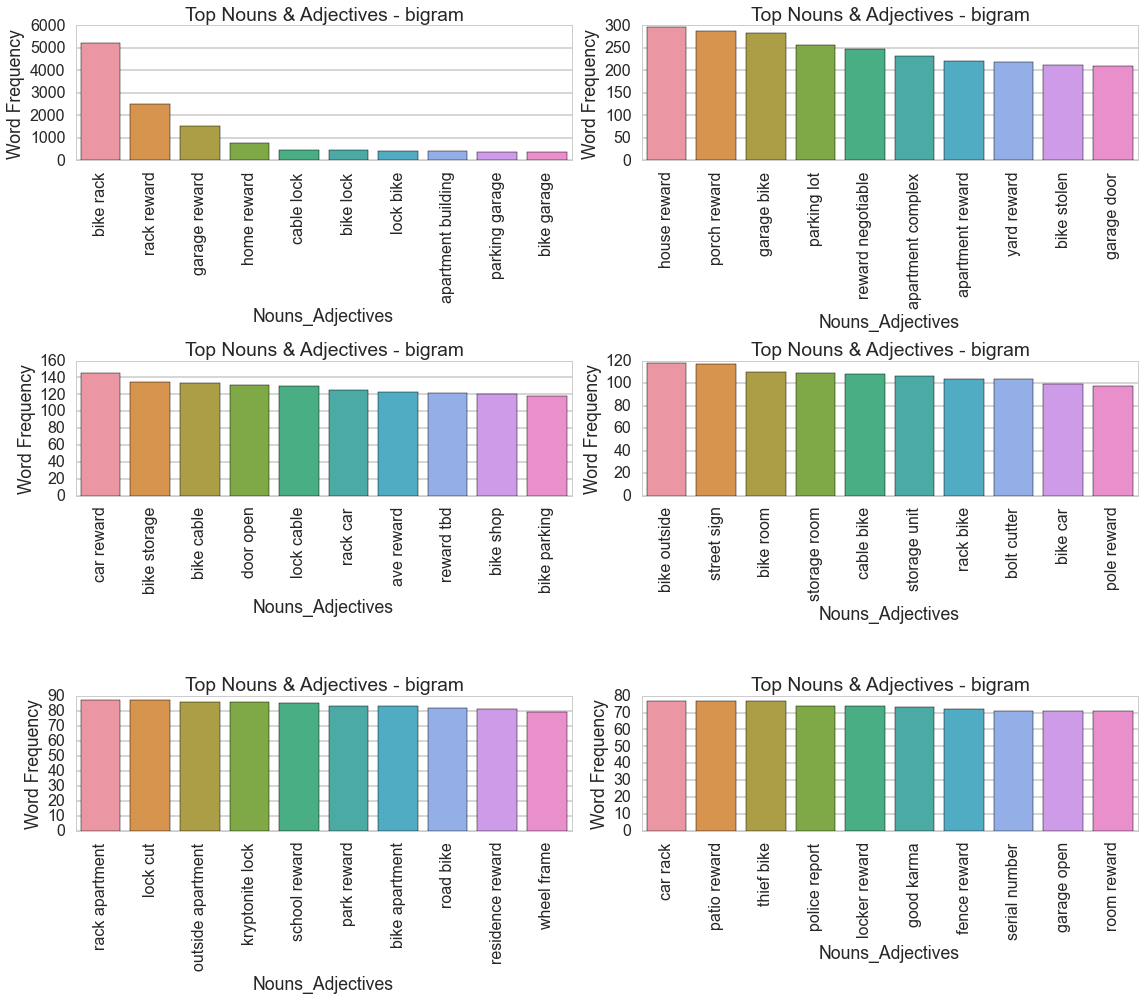

In [16]:
plot_freq_chart(3,2,Sorted_Nouns_Adj_Freq, "Top Nouns & Adjectives - bigram")

### Bigram analysis

The above bigram charts are far more descriptive in aptly identifying some of the key elements of each of the descriptions. As can be noted, some of the bigrams are still vague e.g. 'bike rack' (which also is the most frquently appearing pair of words) or 'cable bike' or 'bike car'. It is definitely likely that a single description of theft had more than 1 combination of the bigrams identified above. e.g. a theft description could have had both these bigrams ['door open' & 'parking garage'] or ['bike stolen' & 'outside apartment']. 

Word pairs such as'rack reward' , 'garage reward' and 'home reward' are unable to provide adequate meaning as we are limiting the parsing to two words.

This yeilds to an interesting question. So how many n-grams would be perfect? This all depends on what exactly are we looking at. The main focus of the theft description analysis is to identify specifics tied to the location from where a bike was stolen. We shall further our analysis with a tri-gram and gauge as to which of the three approaches to use (unigram, bigram or trigram).

In [17]:
#Vectorizer for trigrams
vectorizer_nouns_adj_trigram = CountVectorizer(min_df=2, ngram_range=(3,3), stop_words='english')
nouns_adj_trigram_sparse_matrix = vectorizer_nouns_adj_trigram.fit_transform(bike_df_clean.theft_desc_nouns_adj) 

Nouns_Adj_trigram = vectorizer_nouns_adj_trigram.get_feature_names()
Nouns_Adj_trigram_Counts = np.asarray(nouns_adj_trigram_sparse_matrix.sum(axis=0)).ravel()
Nouns_Adj_trigram_Freq = pd.DataFrame({'Nouns_Adjectives_TRIGRAM': Nouns_Adj_trigram, 'Count':Nouns_Adj_trigram_Counts})
Sorted_Nouns_Adj_trigram_Freq = Nouns_Adj_trigram_Freq.sort(columns='Count', ascending=False)
Sorted_Nouns_Adj_trigram_Freq.to_csv(DATAFILEPATH+'Nouns_Adj_Trigram_frequency.csv',encoding='utf-8')

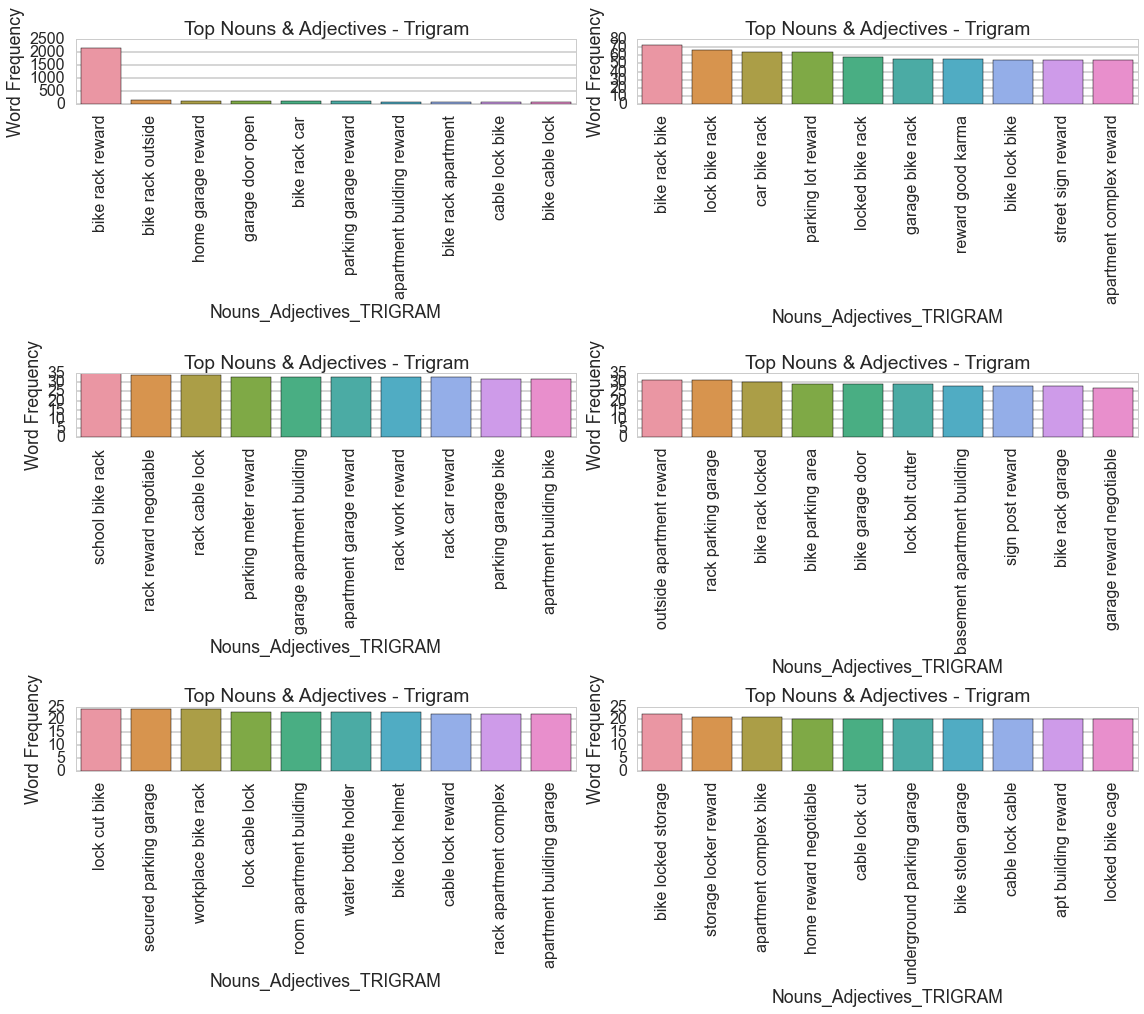

In [18]:
plot_freq_chart(3,2,Sorted_Nouns_Adj_trigram_Freq, "Top Nouns & Adjectives - Trigram")

### Trigram Analysis

It appears that trigram are conveying lots more information about the 'where' that we are interested in. At this point, we should keep in mind that the vast majority of the descriptions had fewer than 5 words. There were innumerous 2 word descriptions (~4200) but as we have already established, bigrams are not performing as well as the trigrams. Secondly, we can also reason that some of the 2 word descriptions could plausibly not all that explanatory and very well could be discarded for our analysis. 

We will now use the trigrams to continue with our analysis.

In [19]:
#Finalize variables for easier naming convention

sparse_matrix_trigram = nouns_adj_trigram_sparse_matrix
vectorizer_trigram = vectorizer_nouns_adj_trigram



In [20]:
#Obtain vocabulary index for trigrams
#Convert trigram sparse matrix to corpus

id2words_trigram= dict((v, k) for k, v in vectorizer_trigram.vocabulary_.iteritems())

corpus_gensim_trigram = gensim.matutils.Sparse2Corpus(sparse_matrix_trigram, documents_columns=False)

print "Corpus shape of trigram: ", corpus_gensim_trigram.sparse.get_shape()
print "Number of words in trigram vocabulary: ", len(vectorizer_trigram.vocabulary_)

Corpus shape of trigram:  (5660, 28534)
Number of words in trigram vocabulary:  5660


### Digging Deeper

At this point, we need to understand if and how these numerous features (5660) in the multidimensional space group together to form clusters that can help us derive a meaningful interpretation from theft description. At this point, we can guess the number of clusters (similar descriptions based on their features) and use that as a starting point. However, a random guess is as good as making none. To make an informed decision aboue the number of clusters, we can resort to randomly sampling a subset of the dataset and performing a hierarchical text analysis. This could act as a starting point for understanding the number of clusters within the corpus. 

We used ward's hierarchical analysis on a sample of XXXXXXXXXX samples to get a glimpse of the cluster structure. 



In [ ]:
################ ********************* Correct XXXXXXXX below to correct number of points   
# Sample XXXXXXXXXXXX  points from dataframe
# Build trigram sparse matrix and full matrix

#For the sake of convenience, used sklearn.cross_validation train_test_split to split dataframe into 
#5% of  training samples.

dftouse = bike_df_clean.copy()

itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.50)
#print len(itrain)
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
#print mask.shape, mask.sum()

rand_sample_text = dftouse['theft_desc_nouns_adj'][mask]

#print len(rand_sample_text)
vectorizer_rand_sample = CountVectorizer(min_df=2, ngram_range=(3,3), stop_words='english')
%time rand_sample_sparse_matrix = vectorizer_rand_sample.fit_transform(rand_sample_text) 
rand_sample_feature_names = vectorizer_rand_sample.get_feature_names()
rand_sample_theft_desc = dftouse['theft_description'][mask].tolist()
rand_sample_nouns_adj = dftouse['theft_desc_nouns_adj'][mask].tolist()

In [ ]:
# Compute Distances
rand_sample_full_matrix = rand_sample_sparse_matrix.toarray()
%time distance = 1 - cosine_similarity(rand_sample_sparse_matrix)


In [ ]:
#TEMP to del

print len(rand_sample_text)
print distance

### Trigram disaster 
 - need to explain why trigrams did not yeild results.
 
 

### ********************** INCLUDE TEXT FROM PREVIOUS NOTEBOOKS ON WHY WE USE 1 - COSINE SIMILARITY for distance

#Credit: http://brandonrose.org/clustering
#ward clustering
%time linkage_matrix = ward(distance) #define the linkage_matrix using ward clustering pre-computed distances

#Credit: http://brandonrose.org/clustering
# Draw dendrogram
fig2, ax2 = plt.subplots(figsize=(15, 20)) # set size
ax2 = dendrogram(linkage_matrix, orientation="right")#, labels=rand_sample_nouns_adj)

plt.tight_layout() #show plot with tight layout
plt.savefig('ward_clusters_trigram_noun_adj.png', dpi=200) #save figure as ward_clusters

#### Note: Given that this is unsupervised learning, the entire dataframe will be used in the analysis instead of splitting in to training and testing sets.

In [45]:
#Perform LDA for different topic size on the trigram
print "Corpus shape:", corpus_gensim_trigram.sparse.shape
num_sig_words=5
num_topics_corpus=range(2,6)
lda_models_Umass_topic_coh={}
lda_models_sig_words={}
for eachtopic in num_topics_corpus:
    lda_text = gensim.models.ldamodel.LdaModel(corpus_gensim_trigram,alpha='auto', id2word=id2words_trigram, num_topics=eachtopic, update_every=1, chunksize=100, passes=5)
    lda_models_Umass_topic_coh[eachtopic]=lda_text.top_topics(corpus_gensim_trigram,num_words=num_sig_words)
    lda_models_sig_words[eachtopic]=lda_text.show_topics(num_topics=eachtopic, num_words=num_sig_words, log=False, formatted=True)

Corpus shape: (5660, 28534)


In [55]:
#Print N significant words for each topic based on each run of LDA with num of topics
def print_sig_words(lda_model_in, num_sig):
    pp = pprint.PrettyPrinter(indent=4)
    print "Printing top ", num_sig, " significant words for each topic in the corpus"
    for key in lda_model_in.keys():    
        print "-------------------------------------------------------------------------------"
        print "Number of topics: ", key

        pp.pprint (lda_model_in[key])

print_sig_words(lda_models_sig_words, num_sig_words)

Printing top  5  significant words for each topic in the corpus
-------------------------------------------------------------------------------
Number of topics:  2
[   u'0.013*bike rack outside + 0.006*bike rack work + 0.005*rack work reward + 0.004*bike rack parking + 0.004*bike rack bike',
    u'0.126*bike rack reward + 0.015*parking lot reward + 0.008*home garage reward + 0.006*parking garage reward + 0.005*garage door open']
-------------------------------------------------------------------------------
Number of topics:  3
[   u'0.170*bike rack reward + 0.010*home garage reward + 0.006*car bike rack + 0.006*bike rack apartment + 0.004*apartment building reward',
    u'0.021*bike rack outside + 0.010*garage door open + 0.009*bike rack work + 0.009*rack work reward + 0.008*bike cable lock',
    u'0.031*parking lot reward + 0.013*parking garage reward + 0.010*garage bike rack + 0.009*parking meter reward + 0.009*bike rack car']
-------------------------------------------------------

In [56]:
#Print N significant words for each topic based on each run of LDA with num of topics
def print_Umass_topics_coh(lda_model_in, num_sig):
    pp = pprint.PrettyPrinter(indent=4)
    print "Printing Umass topic coherence for each topic."
    for key in lda_model_in.keys():    
        print "-------------------------------------------------------------------------------"
        print "Number of topics: ", num_sig

        pp.pprint (lda_model_in[key])

print_Umass_topics_coh(lda_models_Umass_topic_coh,num_sig_words)

Printing Umass topic coherence for each topic.
-------------------------------------------------------------------------------
Number of topics:  5
[   (   [   (0.013263122915601073, u'bike rack outside'),
            (0.0057354050239023313, u'bike rack work'),
            (0.004681920261507079, u'rack work reward'),
            (0.0044373510011269041, u'bike rack parking'),
            (0.0038439069743330468, u'bike rack bike')],
        -56.525192426596796),
    (   [   (0.12624131715591275, u'bike rack reward'),
            (0.014899321329735905, u'parking lot reward'),
            (0.0077128524080241232, u'home garage reward'),
            (0.0061946538165617718, u'parking garage reward'),
            (0.0046872028768865327, u'garage door open')],
        -84.750004089495135)]
-------------------------------------------------------------------------------
Number of topics:  5
[   (   [   (0.020713467096924121, u'bike rack outside'),
            (0.010136480662329573, u'garage door 

In [52]:
#Finalize variables for easier naming convention
#Select which model to use and assign it to final variable

vectorizer_final = vectorizer_nouns
sparse_matrix_final = nouns_sparse_matrix

id2words_final= dict((v, k) for k, v in vectorizer_final.vocabulary_.iteritems())
corpus_gensim_final = gensim.matutils.Sparse2Corpus(sparse_matrix_final, documents_columns=False)

In [53]:
#Perform LDA on final corpus

#Perform LDA for different topic sizes
print "Corpus shape:", corpus_gensim_final.sparse.shape
num_sig_words_final=8
num_topics_final=range(2,6)
lda_final_Umass_topic_coh={}
lda_final_sig_words={}
for eachtopic in num_topics_final:
    lda_text_final = gensim.models.ldamodel.LdaModel(corpus_gensim_final,
                                                     alpha='auto', 
                                                     id2word=id2words_final, 
                                                     num_topics=eachtopic, 
                                                     update_every=1, 
                                                     chunksize=100,
                                                     passes=5)
    lda_final_Umass_topic_coh[eachtopic]=lda_text_final.top_topics(corpus_gensim_final,
                                                                    num_words=num_sig_words_final)
    lda_final_sig_words[eachtopic]=lda_text_final.show_topics(num_topics=eachtopic, 
                                                               num_words=num_sig_words_final, 
                                                               log=False, 
                                                               formatted=True)

Corpus shape: (2823, 28402)


In [54]:
print_sig_words(lda_final_sig_words, num_sig_words_final)

Printing top  5  significant words for each topic in the corpus
-------------------------------------------------------------------------------
Number of topics:  2
[   u'0.313*reward + 0.092*rack + 0.076*garage + 0.031*house + 0.030*home',
    u'0.058*lock + 0.033*hour + 0.029*man + 0.027*half + 0.026*cable']
-------------------------------------------------------------------------------
Number of topics:  3
[   u'0.051*hour + 0.044*man + 0.044*block + 0.042*half + 0.028*st',
    u'0.360*reward + 0.106*rack + 0.087*garage + 0.036*house + 0.034*home',
    u'0.102*lock + 0.046*cable + 0.025*frame + 0.024*mate + 0.024*door']
-------------------------------------------------------------------------------
Number of topics:  4
[   u'0.078*half + 0.073*street + 0.042*mate + 0.036*ave + 0.031*park',
    u'0.107*lock + 0.076*apartment + 0.051*building + 0.049*cable + 0.034*st',
    u'0.063*hour + 0.055*man + 0.033*yard + 0.027*door + 0.015*seat',
    u'0.412*reward + 0.121*rack + 0.100*garage 

In [57]:
print_Umass_topics_coh(lda_final_Umass_topic_coh,num_sig_words_final)

Printing Umass topic coherence for each topic.
-------------------------------------------------------------------------------
Number of topics:  5
[   (   [   (0.058132795471225254, u'lock'),
            (0.03306950777312171, u'hour'),
            (0.028840746434494694, u'man'),
            (0.027020399101847319, u'half'),
            (0.026414711022094511, u'cable')],
        -48.04411336564575),
    (   [   (0.31314911302103787, u'reward'),
            (0.092189158428215137, u'rack'),
            (0.075768262337570141, u'garage'),
            (0.03129639912263639, u'house'),
            (0.029904474443462909, u'home')],
        -50.501119542810564)]
-------------------------------------------------------------------------------
Number of topics:  5
[   (   [   (0.36003181515874921, u'reward'),
            (0.10599237769347238, u'rack'),
            (0.087110118827060934, u'garage'),
            (0.035982530511190124, u'house'),
            (0.034378978396660577, u'home')],
        -